In [1]:
%load_ext autoreload
%autoreload 2


/Users/danatal/tools/miniconda3/envs/psld310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


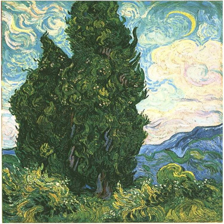

In [2]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
import torch
import numpy as np
from pathlib import Path



def load_image(path, size=224):
    path = Path(path)
    img = Image.open(path).convert("RGB").resize((size, size))
    x = torch.from_numpy((np.array(img).astype("float32") / 255.0)).permute(2,0,1)  # [3,H,W] in [0,1]
    return img, x.unsqueeze(0)  # PIL, [1,3,H,W]

path1 = f"../pics/im1.jpg"
path2 = f"../pics/im2.jpg"
path3 = f"../pics/im3.jpg"


im1, t1 =load_image(path1)
im2, t2 =load_image(path2)
im3, t3 =load_image(path3)

type(im1)
im2

In [32]:
from PIL import Image
from torchvision import transforms
import torch
# Convert PIL → Tensor in [0,1], shape (C, H, W)
to_tensor = transforms.ToTensor()
img_tensor = to_tensor(im2)

# Add batch dimension: (1, C, H, W)
img_tensor = img_tensor.unsqueeze(0)

# Make it a leaf tensor with gradients
img_tensor = img_tensor.clone().detach().requires_grad_(True)

In [37]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
model = AutoModel.from_pretrained('facebook/dinov2-large')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state


In [38]:
last_hidden_states.shape

torch.Size([1, 257, 1024])

In [39]:
out_img = outputs.last_hidden_state











out_img.shape

torch.Size([1, 257, 1024])

In [40]:
# Example: define a dummy loss
loss = out_img.mean()

# Backprop: compute gradient wrt image
loss.backward()



In [41]:
loss.requires_grad

True

In [42]:
loss

tensor(0.0176, grad_fn=<MeanBackward0>)

In [ ]:
import os 
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

In [1]:
import torch, transformers
print("torch:", torch.__version__, "transformers:", transformers.__version__)


: 

In [1]:
print("ok")

ok


In [2]:
import psutil, os
print("RAM used (GB):", (psutil.Process(os.getpid()).memory_info().rss / 1e9))
import torch
if torch.backends.mps.is_available():
    print("MPS allocated (bytes):", torch.mps.current_allocated_memory())

: 

In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests


In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
model = AutoModel.from_pretrained('facebook/dinov2-large').eval()

with torch.enable_grad():
    inputs = processor(images=image, return_tensors="pt")
    x = inputs["pixel_values"].clone().detach().requires_grad_(True)  # leaf var

    outputs = model(pixel_values=x)
    feats = outputs.last_hidden_state          # [B, T, D]

    # make a scalar loss (example): maximize the mean activation of the [CLS] token
    loss = -feats[:, 0].mean()
    loss.backward()

print("‖grad‖ on pixel_values:", x.grad.norm().item())
